# raw 데이터 대상 2차원 시각화 및 클루스터링 결과 시각화

# 필요 라이브러리 로드

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pickle
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook

import warnings

warnings.filterwarnings( 'ignore' )

# 필요 데이터 로드
- 데이터 로드
- 101번부터 120번 유저까지 전처리하여 얻은 데이터프레임을 하나로 결합

In [2]:
l1 = [
    pd.read_pickle('/workspace/Data analysis (zaesoek)/2019/'+str(i)+'_prpDf.pickle') 
    for i in range(101, 121)
]

df = pd.concat(l1, 0)

df = df.drop(df[df['e4AccLen']!=1920].index, 0)
df = df.drop(df[df['e4BvpLen']!=3840].index, 0)
df = df.drop(df[df['e4EdaLen']!=240].index, 0)
df = df.drop(df[df['e4TempLen']!=240].index, 0)

df = df.drop(df[df['mAccLen']<1786].index, 0)
df = df.drop(df[df['mGyrLen']<1786].index, 0)
df = df.drop(df[df['mMagLen']<1786].index, 0)

df.reset_index(inplace=True)

for i in df.index:
    df['e4Hr'][i] = np.mean(df['e4Hr'][i]).reshape(-1, 1)
    df['mGps'][i] = np.mean(df['mGps'][i]).reshape(-1, 1)
    df['mAcc'][i] = df['mAcc'][i][:1786]
    df['mGyr'][i] = df['mGyr'][i][:1786, :3]
    df['mMag'][i] = df['mMag'][i][:1786]

df.head()

,ts,userName,emotionPositive,emotionTension,action,gender,height,weight,e4Acc,e4Bvp,...,mMag,e4AccLen,e4BvpLen,e4EdaLen,e4HrLen,e4TempLen,mAccLen,mGpsLen,mGyrLen,mMagLen
0,1578184440,101,6,2,recreation_etc,F,161.0,52.0,"[[0.9375, -0.25, -0.03125], [0.9375, -0.25, -0...","[[-0.5897236], [-2.0923119], [-3.8966255], [-5...",...,"[[-17.82, -32.34, -69.06], [-17.699999, -32.16...",1920,3840,240,32,240,1786,1,1786,1786
1,1578184560,101,6,2,recreation_etc,F,161.0,52.0,"[[0.9375, -0.21875, -0.0625], [0.9375, -0.2187...","[[-14.854795], [-17.59889], [-20.453917], [-22...",...,"[[-17.88, -31.98, -69.479996], [-17.94, -32.1,...",1920,3840,240,6,240,1786,1,1787,1787
2,1578184620,101,6,2,recreation_etc,F,161.0,52.0,"[[0.921875, -0.21875, -0.140625], [0.921875, -...","[[-5.4048615], [-6.8878326], [-9.298111], [-12...",...,"[[-17.88, -33.0, -69.06], [-17.88, -32.64, -69...",1920,3840,240,3,240,1786,1,1786,1786
3,1578184920,101,6,2,recreation_etc,F,161.0,52.0,"[[-0.28125, -0.578125, 0.734375], [-0.28125, -...","[[10.687408], [13.796631], [16.10376], [16.737...",...,"[[-22.38, -29.16, -68.64], [-21.96, -29.22, -6...",1920,3840,240,8,240,1786,1,1786,1786
4,1578185100,101,6,2,recreation_etc,F,161.0,52.0,"[[-0.6875, -0.40625, 0.578125], [-0.6875, -0.4...","[[-17.65654], [-20.252628], [-23.479042], [-27...",...,"[[-22.68, -29.22, -68.34], [-22.56, -29.099998...",1920,3840,240,59,240,1786,1,1786,1786


# 센서 데이터 1차원으로 변환

In [4]:
df['e4Acc'] = list(np.array(df['e4Acc'].to_list()).reshape(df.shape[0], -1))
df['e4Bvp'] = list(np.array(df['e4Bvp'].to_list()).reshape(df.shape[0], -1))
df['e4Eda'] = list(np.array(df['e4Eda'].to_list()).reshape(df.shape[0], -1))
df['e4Hr'] = list(np.array(df['e4Hr'].to_list()).reshape(df.shape[0], -1))
df['e4Temp'] = list(np.array(df['e4Temp'].to_list()).reshape(df.shape[0], -1))
df['mGps'] = list(np.array(df['mGps'].to_list()).reshape(df.shape[0], -1))
df['mGyr'] = list(np.array(df['mGyr'].to_list()).reshape(df.shape[0], -1))
df['mMag'] = list(np.array(df['mMag'].to_list()).reshape(df.shape[0], -1))
df['mAcc'] = list(np.array(df['mAcc'].to_list()).reshape(df.shape[0], -1))

In [5]:
np.array(df['e4Acc'].to_list()).shape

(37732, 5760)

# train 및 test dataset split

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, shuffle = True, random_state=32)

In [7]:
e4AccData = np.array(test_df['e4Acc'].to_list())
e4BvpData = np.array(test_df['e4Bvp'].to_list())
e4EdaData = np.array(test_df['e4Eda'].to_list())
e4TempData = np.array(test_df['e4Temp'].to_list())
mGyrData = np.array(test_df['mGyr'].to_list())
mMagData = np.array(test_df['mMag'].to_list())
mAccData = np.array(test_df['mAcc'].to_list())

In [8]:
test_df['e4Acc'] = list(e4AccData)
test_df['e4Bvp'] = list(e4BvpData)
test_df['e4Eda'] = list(e4EdaData)
test_df['e4Temp'] = list(e4TempData)
test_df['mGyr'] = list(mGyrData)
test_df['mMag'] = list(mMagData)
test_df['mAcc'] = list(mAccData)

- 센서 데이터를 하나로 묶음

In [9]:
a = np.concatenate([
    np.array(test_df['e4Acc'].to_list()), 
    np.array(test_df['e4Bvp'].to_list()), 
    np.array(test_df['e4Eda'].to_list()), 
    np.array(test_df['e4Hr'].to_list()), 
    np.array(test_df['e4Temp'].to_list()), 
    np.array(test_df['mGps'].to_list()), 
    np.array(test_df['mGyr'].to_list()), 
    np.array(test_df['mMag'].to_list()), 
    np.array(test_df['mAcc'].to_list()), 
], 1)

- User name과 그 유저의 testset의 센서 데이터 차원이 같이 있는 데이터프레임 생성

In [10]:
test_df = test_df[['userName']]
test_df['values'] = list(a)

In [11]:
test_df.head()

,userName,values
20499,114,"[-29.15898453111491, -28.82669145403272, 26.57..."
3345,104,"[2.147307017210909, 0.3555419573000976, -17.86..."
26423,116,"[7.8543310433016185, 7.798730984434352, -16.99..."
29437,117,"[-26.377244464691827, 5.984026420365675, 9.484..."
4061,105,"[-4.121700782901381, 6.3486779420097434, -6.00..."


# 클루스터링 적용 및 결과 확인

In [12]:
weight_arr = np.array(test_df['values'].to_list())
# K means 를 정의하고 학습시킨다.
kmeans_clustering1 = KMeans(n_clusters = 7, max_iter=30000000, random_state = np.random.RandomState(seed=42) )
idx = kmeans_clustering1.fit_predict(weight_arr)

test_df['category'] = idx

In [13]:
test_df.category.value_counts()

1    7285
0     110
2      55
5      52
3      37
6       5
4       3
Name: category, dtype: int64

# T-SNE로 2차원 시각화

In [15]:
df = test_df
X = weight_arr

tsne1 = TSNE(random_state=42)
tsne_points1 = tsne1.fit_transform(X)
        
tsne_df = pd.DataFrame(tsne_points1, index=range(len(X)), columns=['x_coord', 'y_coord'])
tsne_df['category'] = test_df['category']
tsne_df['labels'] = test_df['userName']

# 각 유저 데이터의 분포 확인

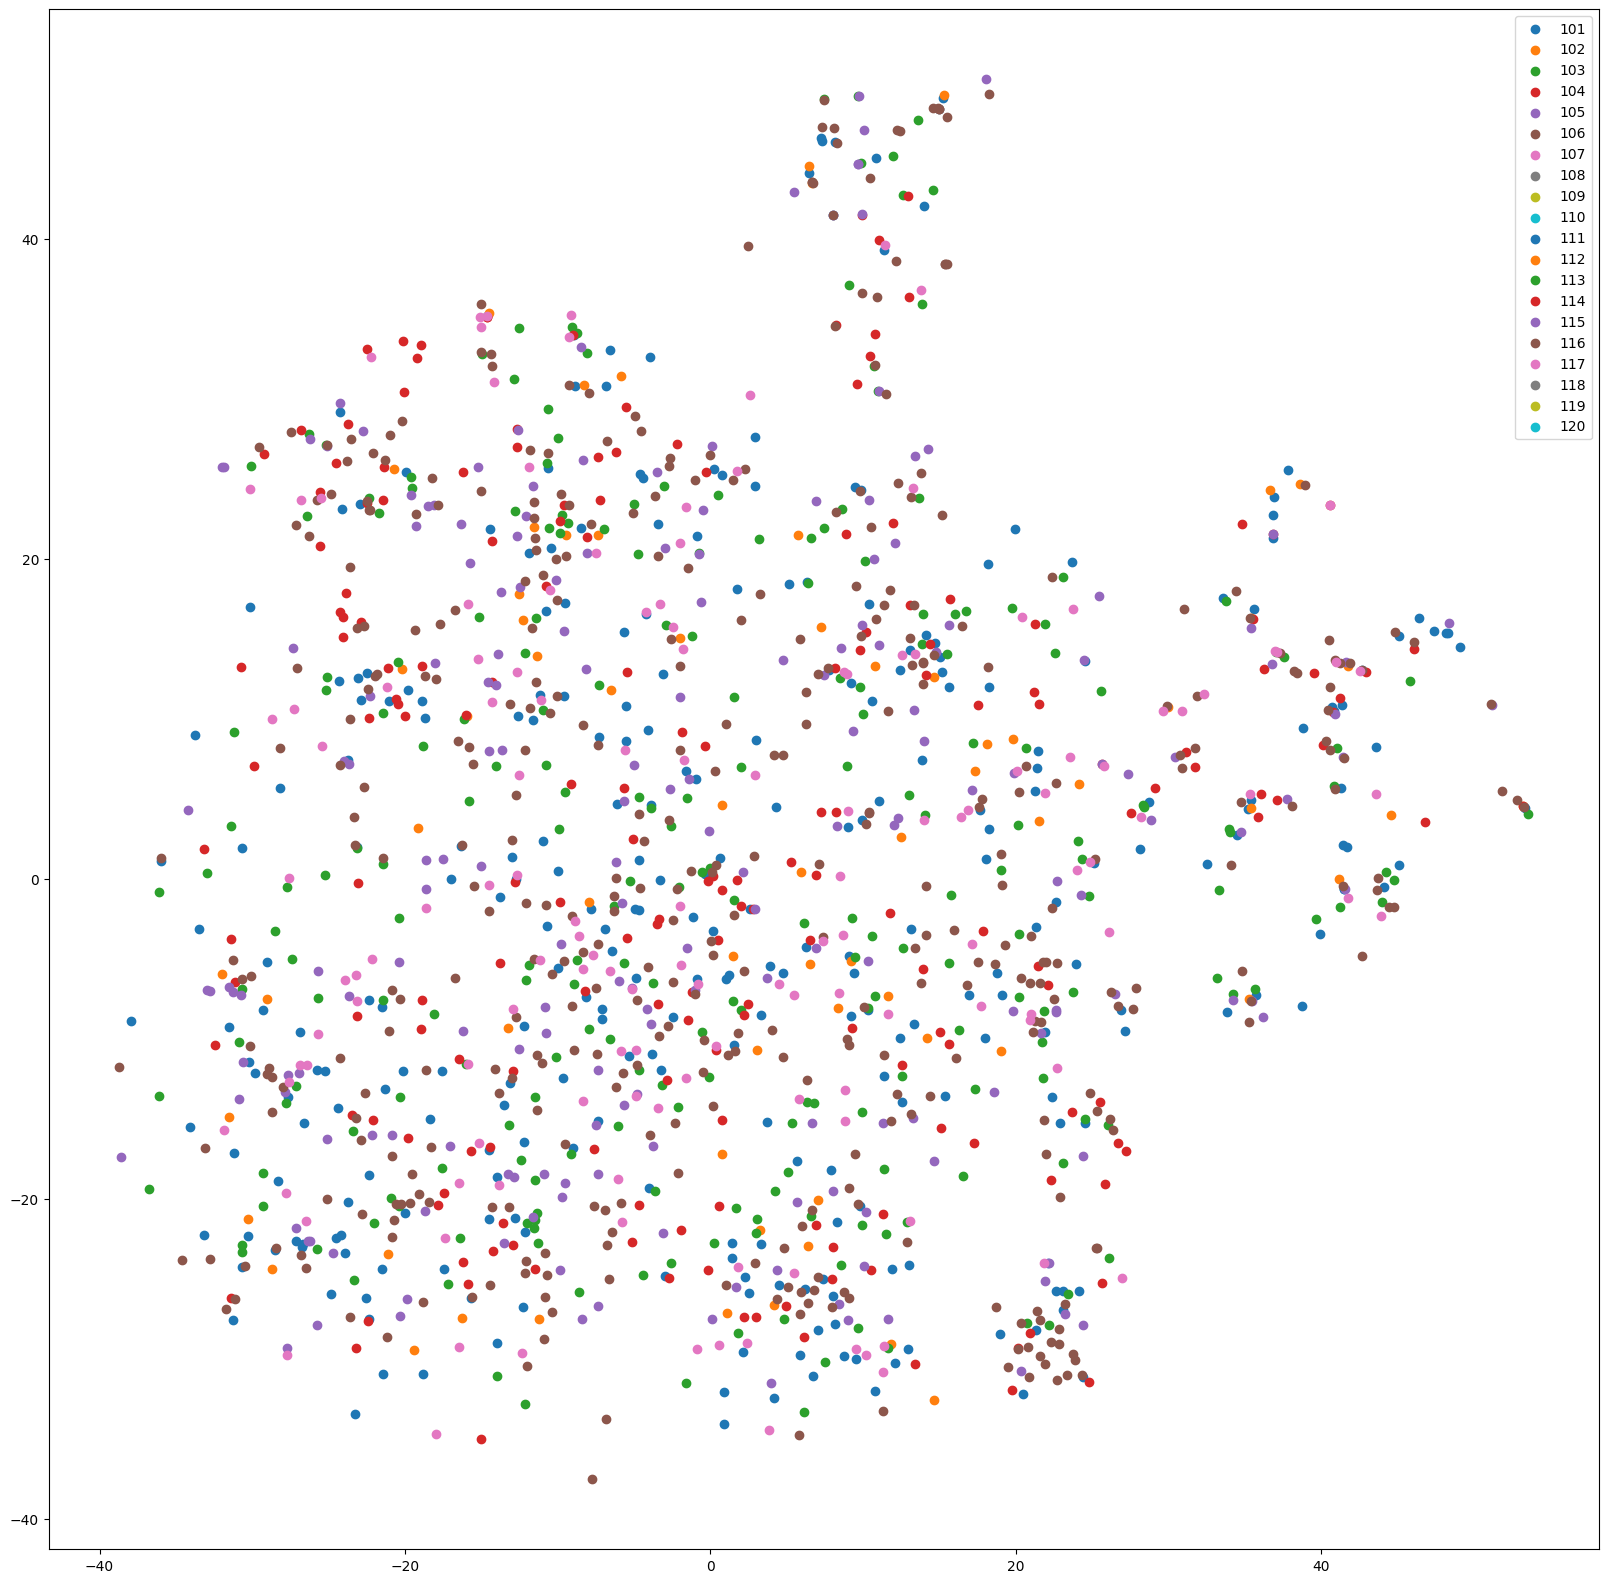

In [18]:
plt.figure(figsize=(20,20))

cluster0x = tsne_df[tsne_df['labels']=='101']['x_coord']
cluster1x = tsne_df[tsne_df['labels']=='102']['x_coord']
cluster2x = tsne_df[tsne_df['labels']=='103']['x_coord']
cluster3x = tsne_df[tsne_df['labels']=='104']['x_coord']
cluster4x = tsne_df[tsne_df['labels']=='105']['x_coord']
cluster5x = tsne_df[tsne_df['labels']=='106']['x_coord']
cluster6x = tsne_df[tsne_df['labels']=='107']['x_coord']
cluster7x = tsne_df[tsne_df['labels']=='108']['x_coord']
cluster8x = tsne_df[tsne_df['labels']=='109']['x_coord']
cluster9x = tsne_df[tsne_df['labels']=='110']['x_coord']
cluster10x = tsne_df[tsne_df['labels']=='111']['x_coord']
cluster11x = tsne_df[tsne_df['labels']=='112']['x_coord']
cluster12x = tsne_df[tsne_df['labels']=='113']['x_coord']
cluster13x = tsne_df[tsne_df['labels']=='114']['x_coord']
cluster14x = tsne_df[tsne_df['labels']=='115']['x_coord']
cluster15x = tsne_df[tsne_df['labels']=='116']['x_coord']
cluster16x = tsne_df[tsne_df['labels']=='117']['x_coord']
cluster17x = tsne_df[tsne_df['labels']=='118']['x_coord']
cluster18x = tsne_df[tsne_df['labels']=='119']['x_coord']
cluster19x = tsne_df[tsne_df['labels']=='120']['x_coord']

cluster0y = tsne_df[tsne_df['labels']=='101']['y_coord']
cluster1y = tsne_df[tsne_df['labels']=='102']['y_coord']
cluster2y = tsne_df[tsne_df['labels']=='103']['y_coord']
cluster3y = tsne_df[tsne_df['labels']=='104']['y_coord']
cluster4y = tsne_df[tsne_df['labels']=='105']['y_coord']
cluster5y = tsne_df[tsne_df['labels']=='106']['y_coord']
cluster6y = tsne_df[tsne_df['labels']=='107']['y_coord']
cluster7y = tsne_df[tsne_df['labels']=='108']['y_coord']
cluster8y = tsne_df[tsne_df['labels']=='109']['y_coord']
cluster9y = tsne_df[tsne_df['labels']=='110']['y_coord']
cluster10y = tsne_df[tsne_df['labels']=='111']['y_coord']
cluster11y = tsne_df[tsne_df['labels']=='112']['y_coord']
cluster12y = tsne_df[tsne_df['labels']=='113']['y_coord']
cluster13y = tsne_df[tsne_df['labels']=='114']['y_coord']
cluster14y = tsne_df[tsne_df['labels']=='115']['y_coord']
cluster15y = tsne_df[tsne_df['labels']=='116']['y_coord']
cluster16y = tsne_df[tsne_df['labels']=='117']['y_coord']
cluster17y = tsne_df[tsne_df['labels']=='118']['y_coord']
cluster18y = tsne_df[tsne_df['labels']=='119']['y_coord']
cluster19y = tsne_df[tsne_df['labels']=='120']['y_coord']

plt.scatter(cluster0x, cluster0y, label='101')
plt.scatter(cluster1x, cluster1y, label='102')
plt.scatter(cluster2x, cluster2y, label='103')
plt.scatter(cluster3x, cluster3y, label='104')
plt.scatter(cluster4x, cluster4y, label='105')
plt.scatter(cluster5x, cluster5y, label='106')
plt.scatter(cluster6x, cluster6y, label='107')
plt.scatter(cluster7x, cluster7y, label='108')
plt.scatter(cluster8x, cluster8y, label='109')
plt.scatter(cluster9x, cluster9y, label='110')
plt.scatter(cluster10x, cluster10y, label='111')
plt.scatter(cluster11x, cluster11y, label='112')
plt.scatter(cluster12x, cluster12y, label='113')
plt.scatter(cluster13x, cluster13y, label='114')
plt.scatter(cluster14x, cluster14y, label='115')
plt.scatter(cluster15x, cluster15y, label='116')
plt.scatter(cluster16x, cluster16y, label='117')
plt.scatter(cluster17x, cluster17y, label='118')
plt.scatter(cluster18x, cluster18y, label='119')
plt.scatter(cluster19x, cluster19y, label='120')

plt.legend(loc='best')
plt.show()

# 클러스터링 결과 시각화

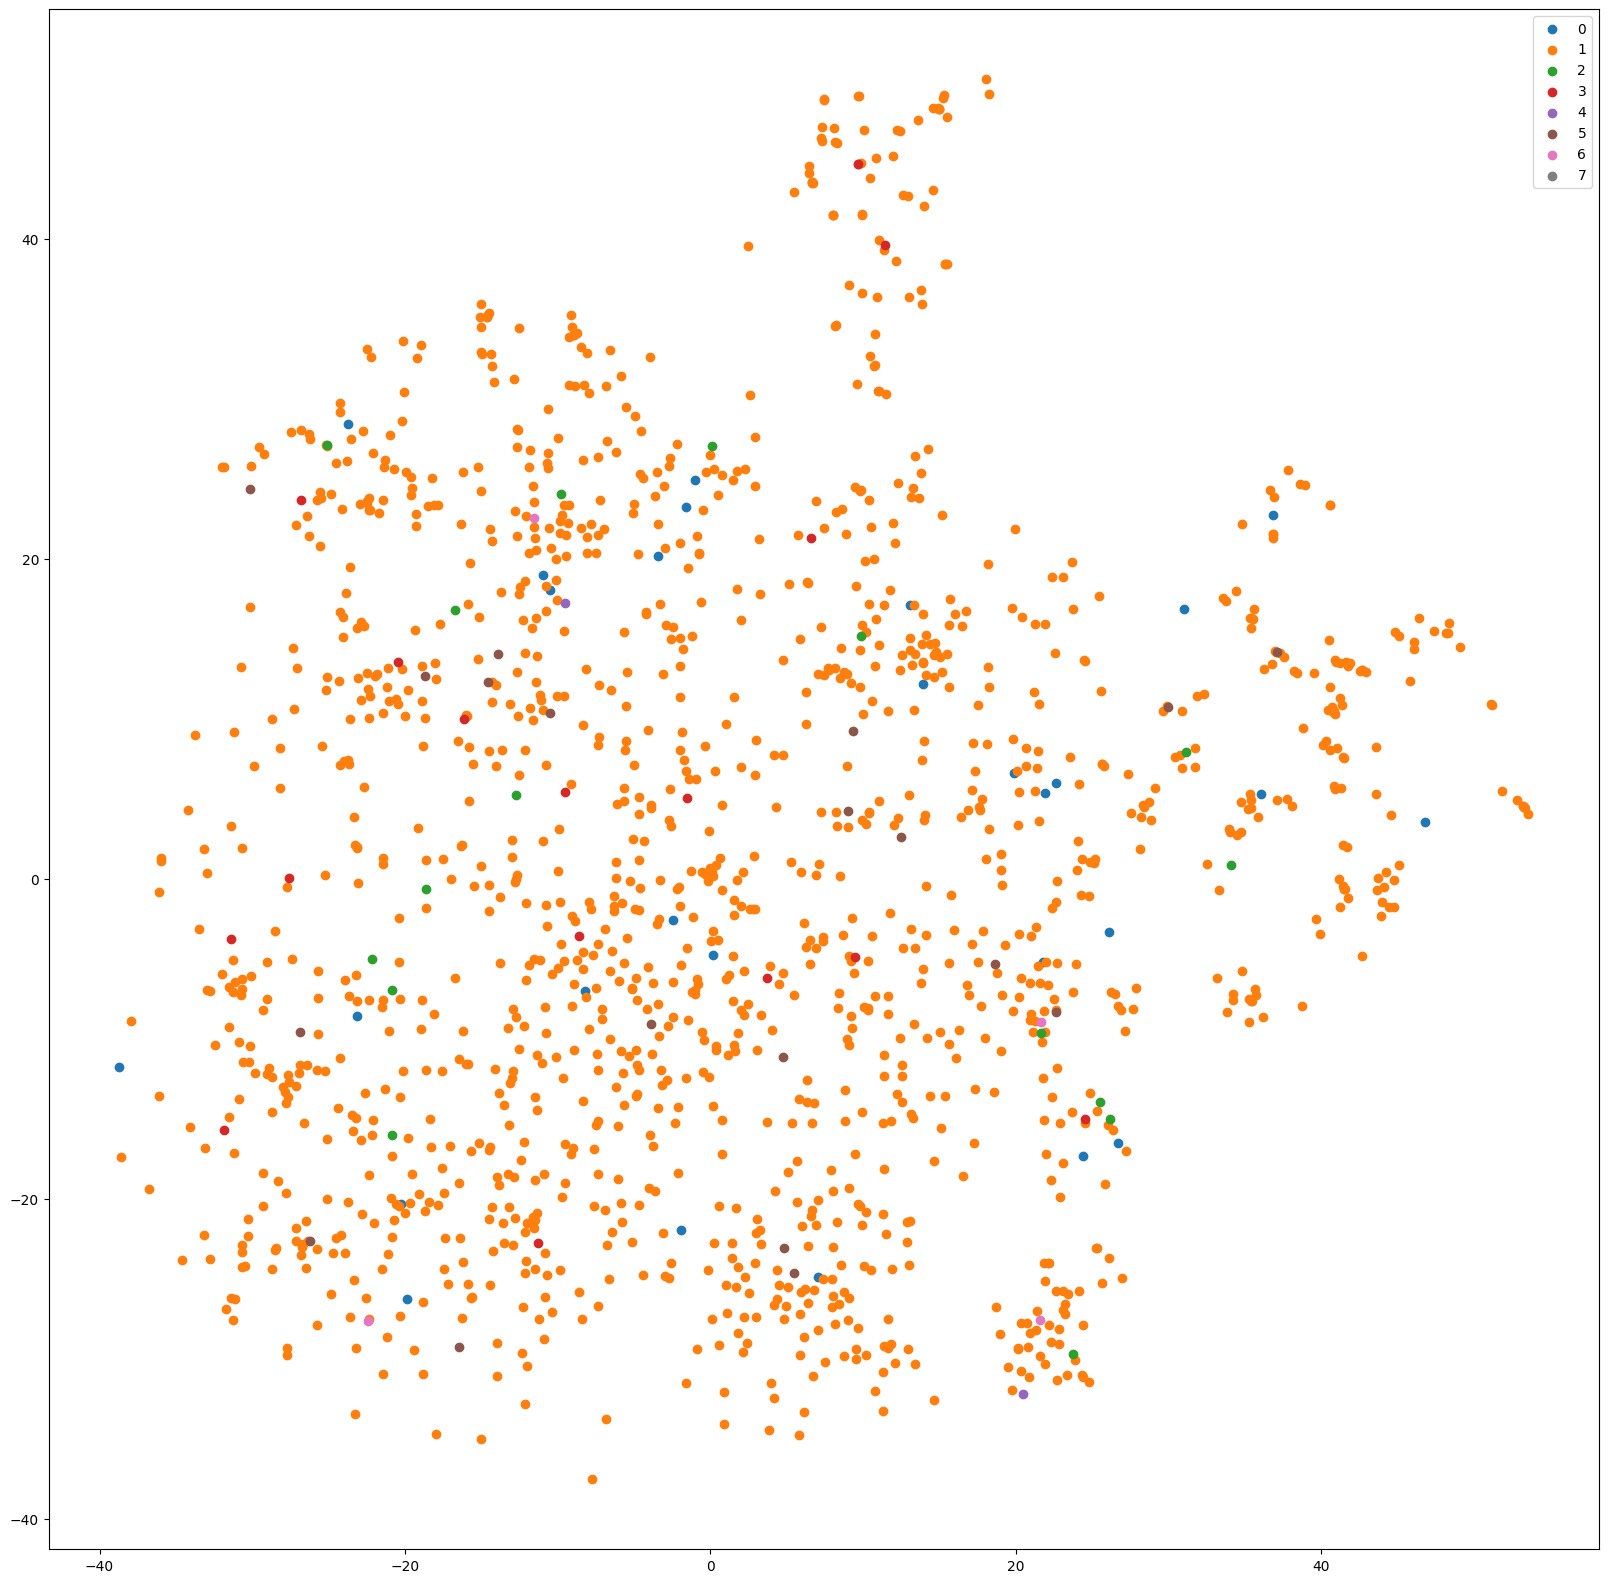

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,20))

cluster0x = tsne_df[tsne_df['category']==0]['x_coord']
cluster1x = tsne_df[tsne_df['category']==1]['x_coord']
cluster2x = tsne_df[tsne_df['category']==2]['x_coord']
cluster3x = tsne_df[tsne_df['category']==3]['x_coord']
cluster4x = tsne_df[tsne_df['category']==4]['x_coord']
cluster5x = tsne_df[tsne_df['category']==5]['x_coord']
cluster6x = tsne_df[tsne_df['category']==6]['x_coord']
cluster7x = tsne_df[tsne_df['category']==7]['x_coord']

cluster0y = tsne_df[tsne_df['category']==0]['y_coord']
cluster1y = tsne_df[tsne_df['category']==1]['y_coord']
cluster2y = tsne_df[tsne_df['category']==2]['y_coord']
cluster3y = tsne_df[tsne_df['category']==3]['y_coord']
cluster4y = tsne_df[tsne_df['category']==4]['y_coord']
cluster5y = tsne_df[tsne_df['category']==5]['y_coord']
cluster6y = tsne_df[tsne_df['category']==6]['y_coord']
cluster7y = tsne_df[tsne_df['category']==7]['y_coord']

plt.scatter(cluster0x, cluster0y, label='0')
plt.scatter(cluster1x, cluster1y, label='1')
plt.scatter(cluster2x, cluster2y, label='2')
plt.scatter(cluster3x, cluster3y, label='3')
plt.scatter(cluster4x, cluster4y, label='4')
plt.scatter(cluster5x, cluster5y, label='5')
plt.scatter(cluster6x, cluster6y, label='6')
plt.scatter(cluster7x, cluster7y, label='7')

plt.legend(loc='best')
plt.show()